In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
from sklearn.preprocessing import MinMaxScaler , PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# 한글 문제
# matplotlit의 기본 폰트에서 한글 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [5]:
# 연도별 데이터 통합
def load():
    data=glob('./data/final*')
    total=[]
    for i in data:
        total.append(pd.read_csv(i,encoding='cp949'))
    tot=pd.concat(total,axis=0)
    return tot

In [6]:
tot=load()

In [7]:
tot.head()

,DAY,TIME,STATION_NAME,GU,UP_POP,DOWN_POP,RAIN,HUMN,SNOW,SKY,ONDO,WINDD,WINDS,PM10,PM25
0,19/01/01,10:00,가락시장,송파구,300,307,0.0,44,0.0,3,-4.9,13,1.6,47,35
1,19/01/01,11:00,가락시장,송파구,377,450,0.0,41,0.0,1,-3.7,13,2.5,40,25
2,19/01/01,12:00,가락시장,송파구,527,498,0.0,47,0.0,3,-2.8,13,2.8,42,28
3,19/01/01,13:00,가락시장,송파구,485,453,0.0,49,0.0,3,-1.5,12,2.7,45,30
4,19/01/01,14:00,가락시장,송파구,562,496,0.0,51,0.0,3,-1.7,13,3.5,42,26


# 전처리 함수

In [14]:
# # 시간대별 지하철 이용객수 그래프
# def visual(df):
#     df2=df.copy()
#     df2=feat(df2)
#     df2['TIME']=[int(i.split(':')[0]) for i in df2['TIME']]
#     pivot=pd.pivot_table(df2,index='TIME',values='TOTAL',aggfunc='sum')

#     sns.barplot(pivot.index,pivot['TOTAL'])

In [15]:
# 합계와 시간대 컬럼 생성
def feat(dt):
    df=dt.copy()
    df['TOTAL']=df['UP_POP']+df['DOWN_POP']
    df['T']=[0 if (int(i.split(':')[0])>19) or (int(i.split(':')[0])<17) else 1 for i in df['TIME']]
    return df

In [16]:
# 가중치 컬럼 생성 후 필요없는 컬럼 제거
def weight(dt):
    df=dt.copy()
    mean=pd.pivot_table(df,index='STATION_NAME',values='TOTAL')
#     mm=MinMaxScaler()
#     w=mm.fit_transform(mean)
    mean['W']=mean
    df=pd.merge(df.drop(['UP_POP','DOWN_POP'],axis=1),mean.drop(['TOTAL'],axis=1),on='STATION_NAME')
    return df
    

In [17]:
# 로그변환
def log_trans(dt):
    df=dt.copy()
    feat=df.columns.drop('ONDO')
    df[feat]=np.log1p(df[feat])
    return df
    

In [32]:
# 모든함수 적용
def pre(dt):
    df=dt.copy()
    df=feat(df)
    df=weight(df).drop(['DAY','GU','TIME'],axis=1).set_index('STATION_NAME')
    df=log_trans(df)
    X=df.drop('TOTAL',axis=1)
    Y=df[['TOTAL']]
    return X,Y

# 로그변환 전 데이터

In [33]:
X_n,Y_n=pre(tot)

In [34]:
X_n.head()

,RAIN,HUMN,SNOW,SKY,ONDO,WINDD,WINDS,PM10,PM25,T,W
STATION_NAME,,,,,,,,,,,
가락시장,0.0,44,0.0,3,-4.9,13,1.6,47,35,0,2559.875
가락시장,0.0,41,0.0,1,-3.7,13,2.5,40,25,0,2559.875
가락시장,0.0,47,0.0,3,-2.8,13,2.8,42,28,0,2559.875
가락시장,0.0,49,0.0,3,-1.5,12,2.7,45,30,0,2559.875
가락시장,0.0,51,0.0,3,-1.7,13,3.5,42,26,0,2559.875


In [35]:
Y_n.head()

,TOTAL
STATION_NAME,
가락시장,607
가락시장,827
가락시장,1025
가락시장,938
가락시장,1058


In [36]:
total_n=pd.concat([X_n,Y_n],axis=1)

In [37]:
total_n.head()

,RAIN,HUMN,SNOW,SKY,ONDO,WINDD,WINDS,PM10,PM25,T,W,TOTAL
STATION_NAME,,,,,,,,,,,,
가락시장,0.0,44,0.0,3,-4.9,13,1.6,47,35,0,2559.875,607
가락시장,0.0,41,0.0,1,-3.7,13,2.5,40,25,0,2559.875,827
가락시장,0.0,47,0.0,3,-2.8,13,2.8,42,28,0,2559.875,1025
가락시장,0.0,49,0.0,3,-1.5,12,2.7,45,30,0,2559.875,938
가락시장,0.0,51,0.0,3,-1.7,13,3.5,42,26,0,2559.875,1058


# 로그변환 후 데이터

In [25]:
X,Y=pre(tot)

In [26]:
total=pd.concat([X,Y],axis=1)

In [27]:
total.head()

,RAIN,HUMN,SNOW,SKY,ONDO,WINDD,WINDS,PM10,PM25,T,W,TOTAL
STATION_NAME,,,,,,,,,,,,
가락시장,0.0,3.806662,0.0,1.386294,-4.9,2.639057,0.955511,3.871201,3.583519,0.0,7.848104,6.410175
가락시장,0.0,3.737670,0.0,0.693147,-3.7,2.639057,1.252763,3.713572,3.258097,0.0,7.848104,6.719013
가락시장,0.0,3.871201,0.0,1.386294,-2.8,2.639057,1.335001,3.761200,3.367296,0.0,7.848104,6.933423
가락시장,0.0,3.912023,0.0,1.386294,-1.5,2.564949,1.308333,3.828641,3.433987,0.0,7.848104,6.844815
가락시장,0.0,3.951244,0.0,1.386294,-1.7,2.639057,1.504077,3.761200,3.295837,0.0,7.848104,6.965080


# 로그변환 전 후 왜도 및 Histplot

In [38]:
total_n.skew()

RAIN     21.202047
HUMN      0.247945
SNOW     49.610664
SKY       0.104056
ONDO     -0.290811
WINDD    -0.640466
WINDS     0.669217
PM10      6.607433
PM25      2.445244
T         1.278027
W         1.897053
TOTAL     3.205975
dtype: float64

In [29]:
total.skew()

RAIN      7.075277
HUMN     -0.593687
SNOW     44.272759
SKY       0.000659
ONDO     -0.290811
WINDD    -1.291296
WINDS    -0.312185
PM10     -0.210985
PM25     -0.371576
T         1.278027
W         0.239648
TOTAL    -0.079852
dtype: float64

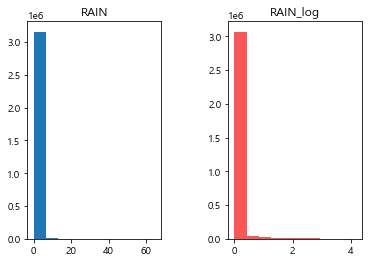

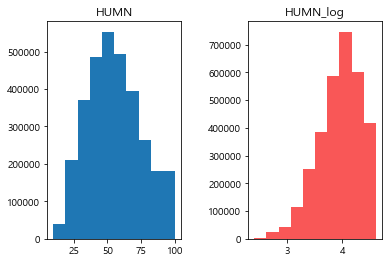

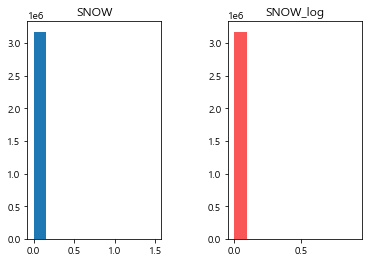

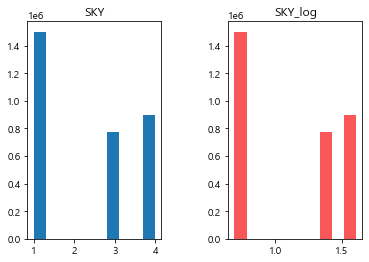

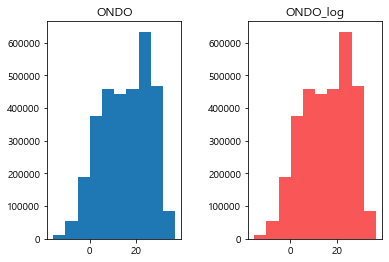

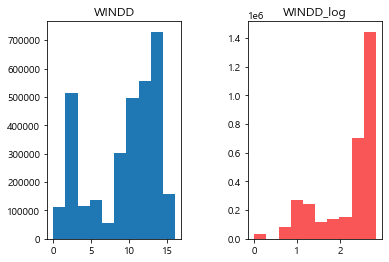

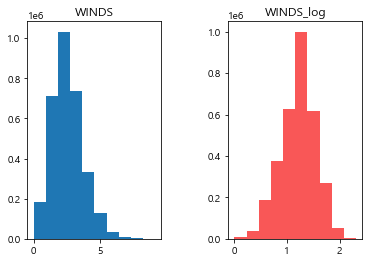

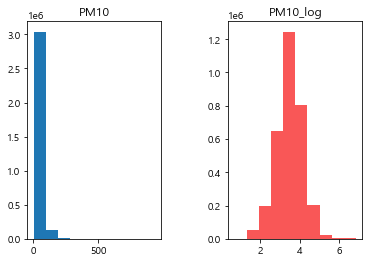

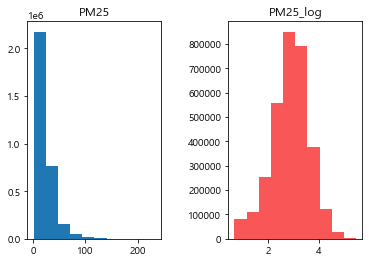

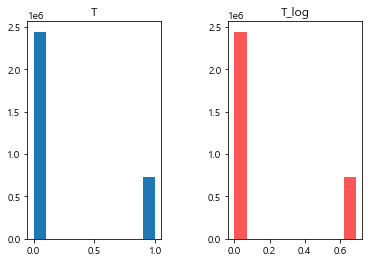

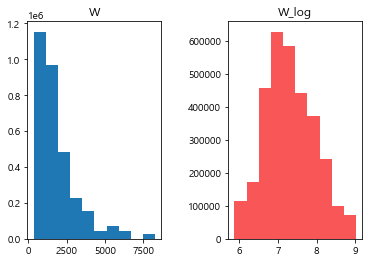

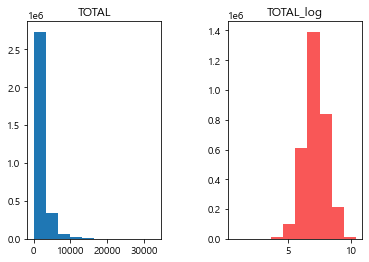

In [39]:
for i in total_n:
    fig, axs = plt.subplots(1,2)
    plt.subplots_adjust(wspace=0.5)
#     sns.histplot(total_n[i],ax=axs[0],bins=10)
#     plt.y
#     sns.histplot(total[i],ax=axs[1],bins=10)
    axs[0].hist(total_n[i])
    axs[0].set_title(i)
    axs[1].hist(total[i],color='#F95757')
    axs[1].set_title(i+'_log')
    plt.show()

## 다중 공선성

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_df(x):
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

df=vif_df(X)

df
# vif값이 10을 넘는 변수가 없으므로 다중공선성 문제 없음data=glob('./data/final*')

,features,VIF Factor
0,RAIN,1.170889
1,HUMN,82.666651
2,SNOW,1.012652
3,SKY,10.606992
4,ONDO,3.551380
5,WINDD,16.002021
6,WINDS,16.492945
7,PM10,112.489837
8,PM25,70.746769
9,T,1.323293


## 회귀 모델링

In [126]:
def lr_eval(X,Y,method=None):
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
    if method==None:
        lr=LinearRegression()
        lr.fit(X_train,y_train)

        pred=lr.predict(X_train)
        pred_t=lr.predict(X_test)
        

#     elif method=='Poly':
#         poly=Pipeline([('poly',PolynomialFeatures(degree=2)),
#                       ('linear',LinearRegression())])
#         lr=poly.fit(X_train,y_train)
        
#         pred=lr.predict(X_train)
#         pred_t=lr.predict(X_test)

    print('Train Data MSE : {0}, MAE : {1}'.format(mean_squared_error(y_train,pred),mean_absolute_error(y_train,pred)))
    print('Test Data MSE : {0}, MAE : {1}'.format(mean_squared_error(y_test,pred_t),mean_absolute_error(y_test,pred_t)))
    return lr

In [131]:
X_drop=X.drop(['T'],axis=1)

In [133]:
lr_drop=lr_eval(X_drop,Y)

Train Data MSE : 0.30581270323639675, MAE : 0.4149984508146742
Test Data MSE : 0.3066347347703004, MAE : 0.41506560315784774


In [130]:
lr=lr_eval(X,Y)

Train Data MSE : 0.26186214238942457, MAE : 0.38159704826805907
Test Data MSE : 0.2619874525209276, MAE : 0.3814228249120615
